###**7. LightGBM**
**Intro**
XGBoost의 장단점
- 장점: 매우 뛰어난 부스팅 알고리즘
- 단점: 여전히 학습시간이 오래걸림

(대용량 데이터의 경우 만족할 만한 학습 성능을 기대하려면 많은 CPU 콩러를 가진 시스템에서 높은 병렬도로 학습을 진행해야 함)

  ->  LightGBM 사용

LightGBM의 장단점
- 장점
  - XGBoost보다 학습에 걸리는 시간이 훨씬 적다 (더 빠른 학습과 예측 수행 시간)
  - 메모리 사용량도 상대적으로 적다 (더 작은 메모리 사용량)
  - 카테고리형 피처의 자동 변환과 최적 분할 (원-핫 인토딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 변환 수행)
- 단점: 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉽다 (보통 10,000건 이하)

LightGBM의 특징
- 리프 중심 트리분할(Leaf Wise) 방식을 사용

1) 기존 트리 분할 방법 특징
- 장점
   - 트리의 깊이가 최소화 됨
   - 오버피팅에 보다 강한 구조가 될 수 있음
- 단점: 상대적로 균형을 맞추기 위한 시간이 더 필요

2) lightGBM의 리프 중심 트리 분할의 특징
- 트리의 균형을 맞추지 않고, 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리를 생성
- 학습을 반복할 수록 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화할 수 있음

**LightGBM 설치**




In [82]:
!pip install numpy==1.24.4
!pip install scikit-learn==1.2.2
!pip install xgboost==1.7.6
!pip install lightgbm==3.3.2

In [83]:
import lightgbm
from lightgbm import LGBMClassifier

**LightGBM 하이퍼파라미터**

XGBoost와 많은 부분이 유사하나, 리프 노드가 계속 분할 되면서 트리의 깊이가 깊어지므로 이러한 트리 특성에 맞는 하이퍼 파라미터 설정이 필요함
- 주요 파라미터
  - num_iteractions: 반복 수행하려는 트리의 개수를 지정함
  - learning_rate: 0에서 1사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값
  - max_depth: 트리 기반 알고리즘의 max_depth와 동일
  - min_data_in_leaf: 결정 트리의 min_samples_leaf와 같은 파라미터
  - num_leaves: 하나의 트리가 가질 수 있는 최대 리프 개수
  - boosting: 부스팅의 트리를 생성하는 알고리즘을 기술
    - gbdt: 일반적인 그래디언트 부스팅 결정 트리
    - rf: 랜덤 포레스트
  - bagging_fraction: 트리가 커져서 과적합되는 것을 제어하기 위해서 데이터를 샘플링하는 비율을 지정함
  - feature_fraction: 개별 트리를 학습할 대마다 무작위로 선택하는 피처의 비율
  - lambda_l2: L2 regulation 제어를 위한 값
  - lambda_l1: L1 regulation 제어를 위한 값
- learning task 파라미터
  - objective: 최솟값을 가져야 할 손실함수를 정의 (XGBoost와 동일한 objective 파라미터)

**하이퍼파라미터 튜닝방안**

- num_leaves의 개수를 중심으로 min_child_samples. max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안
  - num_leaves: 개별 트리가 가질 수 있는 최대 리프의 개수로, lightGBM 모델의 복잡도를 제어하는 주요 파라미터
  - min_data_in_leaf(min_child_samples): 과적합을 개선하기 위한 중요 파라미터
  - max_depth: 명시적으로 깊이의 크기를 제한함
- learning_rate를 작게 하면서 n_estimators를 크게하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 사용해도 됨
- reg_lambda, reg_alpha와 같은 regularization을 적용
- 데이터 샘플링 레코드 개수를 줄이기 위한 colsample_bytree, subsample 파라미터의 적용


**파이썬래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교**

대부분 사이킷런 래퍼 LightGBM 클래스와 사이킷런 래퍼 XGBoost 클래스는 위에서 보았 듯 많은 하이퍼 파라미터가 동일하나, 일부분의 경우 사이킷런 래퍼 클래스를 제공하지 않던 초기의 파이썬 래퍼 LightGBM과 사이킷런 래퍼 LightGBM 하이퍼 파라미터가 존재한다.
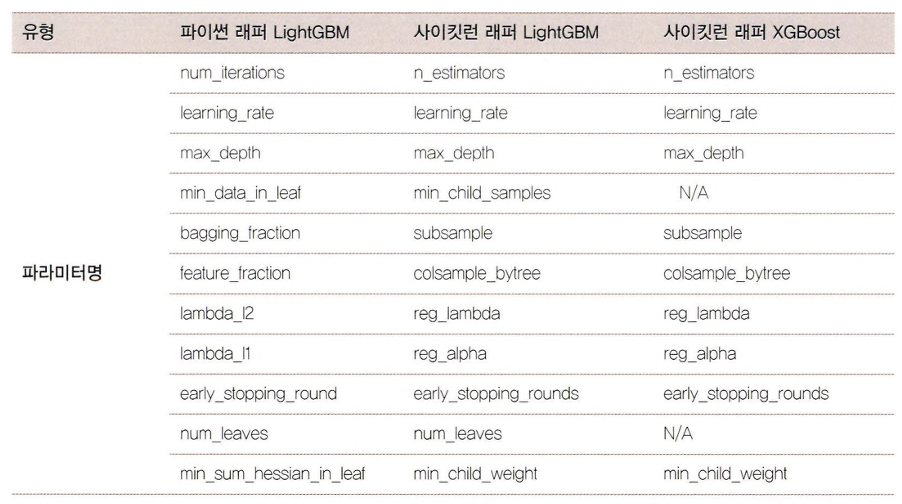

**LightGBM 적용 - 위스콘신 유방암 예측**

In [84]:
# LightGBM의 파이선 패키지인 llightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']=dataset.target
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df['target']

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테ㅔ스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals= [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


여기서 조기 중단으로 111번 반복까지만 수행하고 학습을 종료한 것을 확인할 수 있다. 이를 기반으로 예측 성능을 평가해보자.

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score,roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None): # ROC AUC는 예측 확률값 기반으로 계산 > 함수의 인자로 받을 수 있도록
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [86]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1:0.9677, AUC:0.9877


여기서 정확도가 약 95.61%로 나타난느 것을 확인할 수 있다. 이제 이를 시각화해보자.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

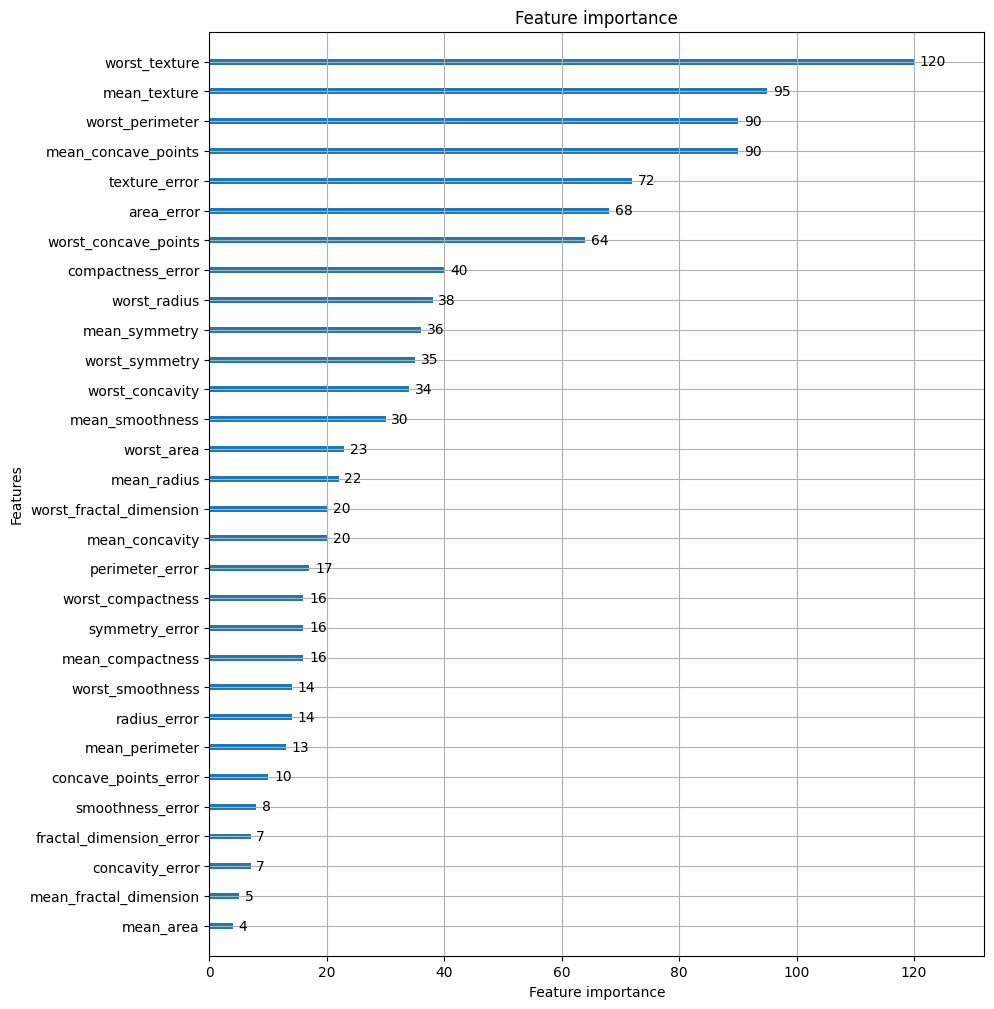

In [87]:
# plot_importance()를 이용하여 feature의 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

###**8. 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝**

XGBoost나 LightGBM은 성능이 매우 뛰어난 알고리즘이나, 하이퍼 파라미터 개수가 다른 알고리즘에 비해 많다는 단점을 가지고 있다. 따라서 실무의 대용량 학습 데이터에 GridSearch 방식으로 최적 하이퍼 파라미터를 찾으려면 많은 시간이 소모된다.

In [88]:
params = {
    'max_depth'== [10, 20, 30, 40, 50], 'num_leaves' == [35, 45, 55, 65],
    'colsample_bytree' == [0.5, 0.6, 0.7, 0.8, 0.9], 'subsample' == [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_child_weight' == [10, 20, 30, 40], 'reg_alpha' == [0.01, 0.05,0.1]
}

이렇게 진행한느 경우 기하급수적으로 늘어나는 하이퍼 파라미터 최적화 시간 때문에 어쩔 수 없이 하이퍼 파라미터의 개수를 줄이거나 개별 하이퍼 파리미터의 범위를 줄여야 한다.
따라서 GridSearch 방식보다는 베이지안 최적화 기법을 사용한다.

** 베이지안 최적화 개요**

step1
- 최초에는 랜덤하게 하이퍼 파라미터들을 샘플링하고, 성능 결과를 관측한다. 아래 그림에서 검은색원은 특정 하이퍼 파라미터가 입력되었을 때 관측되는 성능 지표 결괏값을 뜻하며 주황색 사선은 찾아야할 목표 최적함수가 된다.
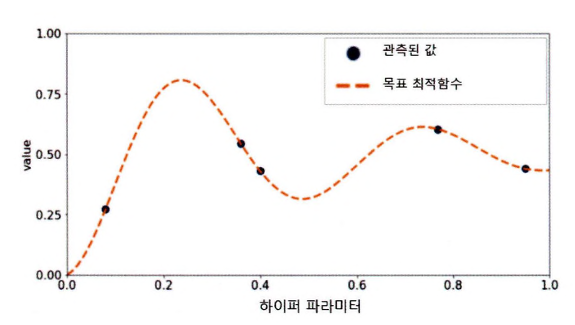

step2
- 관측된 값을 기반으로 대체 모델은 최적 함수를 추정하게 된다. 아래 그림에서 파란색 실선은 대체 모딜이 추정한 최적 함수이고, 옅은 파란색으로 되어있는 영역은 예측된 함수의 신뢰구간을 의미한다. 추정된 함수의 결괏값 오류 편차를 의미하며 추정 함수의 불확실성을 나타낸다. 최적 관측값은 y축 value에서 가장 높은 값을 가질 때의 하이퍼 파라미터이다.
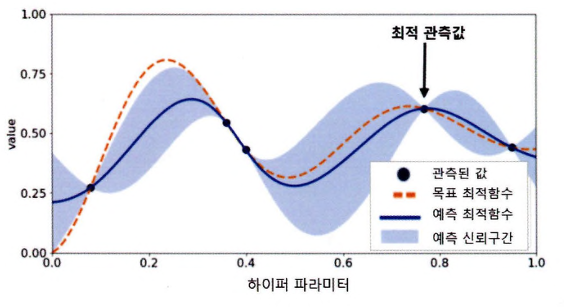

step3
- 추정된 최적함수를 기반으로 획득 함수는 다음으로 관측할 하이퍼 파라미터 값을 계산한다. 획득 함수는 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아 다음에 관측할 하이퍼 파라미터의 태체 모델에 전달한다.
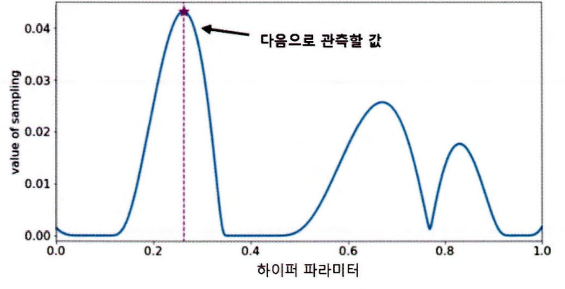

step4
- 획득 함수로부터 전달된 하이퍼 파라미터를 수행하며 관측된 값을 기반으로 대체 모델은 갱신된어 다시 최적 함수를 예측 추정한다.
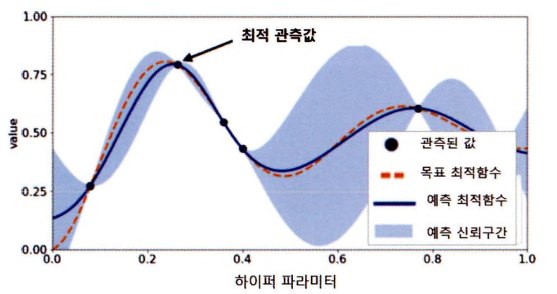

이런 방식으로 특정 횟수 만큼 반복하게 되면 대체 모델의 불확실성이 개선되고 점차 정확한 최적 함수 추정이 가능하게 된다.


**HyperOPt 사용하기**

In [89]:
pip install hyperopt

HyprtOpt를 활용하는 주요 로직
- 입력 변수명과 입력값의 검색 공간(Search Space)의 설정
- 목적 함수(Objective Function)의 설정
- 목적 함수의 반환 최솟값을 가지는 최적 입력값을 유추하는 것

In [90]:
from hyperopt import hp

# -10 ~ 10까지 1 간격을 가지는 입력 변수 x와 -15~15까지 1간격으로 입력 변수 y 설정
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1)}

- hp.uniform(label, low, high, q): label로 지정된 입력값 변수 검색 공간을 최솟값 low에서 최댓값 high까지 정규 분포 형태의 검색 공간 설정
- hp.randint(label, upper): 0부터 최댓값 upper낒; ramdom한 정수값으로 검색 공간 설정.


In [91]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
  x= search_space['x']
  y= search_space['y']
  retval = x**2 - 20*y

  return retval

In [92]:
from hyperopt import fmin, tpe, Trials
# 입력 결괏값을 저장한  Trials 객체값 생성.
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals = 5)로 찾아냄.
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5, trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 198.47trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [93]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20, trials=trial_val, rstate=np.random.default_rng(seed=0))

100%|██████████| 20/20 [00:00<00:00, 274.45trial/s, best loss: -296.0]


fmin() 함수 수행 시 인자로 들어가는 Trials 객체는 함수의 반복 수행 시마다 입력되는 변숫 값들과 함 수 반환값을 속성을 가지게 됨.

In [94]:
# fmin()에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss': 함수 반환값, 'status': 반환상태값}와 같은 딕셔너리임.
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


여기서 fmin()함수는 20회의 반복 수행을 했으므로 results의 속성은 loss와 status를 키값으로 가지는 20개의 딕셔너리를 개별 원소로 가지는 리스트로 구성되어있음을 알 수 있다.

In [95]:
# Trials 객체의 vals 속성에 {'입력변수명": 개별 수행 시마다 입력된 값 리스트} 형태로 저장됨.
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [96]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성.
losses = [loss_dict['loss'] for loss_dict in trial_val.results]\

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y':trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


**HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화**

In [97]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [98]:
from hyperopt import hp

# max_depth는 5에서 20까지 1 간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                    }

In [99]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을 수록 더 좋은 수치임. -1*정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
  # 수행 시간 절약을 위해 nestimators는 100으로 축소
  xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                          min_child_weight = int(search_space['min_child_weight']),
                          learning_rate = search_space['learning_rate'],
                          colsample_bytree = search_space['colsample_bytree'],
                          eval_metric='logloss'
                          )
  accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

  # accuracy는 cv=3개수 만큼 roc-auc 결과를 리스트로 가짐, 이를 평균해서 반환하되 -1을 곱함.
  return {'loss': -1*np.mean(accuracy), 'status': STATUS_OK}

In [100]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space = xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9)
            )
print('best:', best)

100%|██████████| 50/50 [00:40<00:00,  1.22trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.9599446282177103, 'learning_rate': 0.15480405522751015, 'max_depth': 6.0, 'min_child_weight': 2.0}


In [101]:
print('colsample_bytree:{0}, learning_rate:{1}, max_deepth:{2}, min_child_seight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])
))

colsample_bytree:0.95994, learning_rate:0.1548, max_deepth:6, min_child_seight:2


In [102]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate = round(best['learning_rate'],5),
                            max_depth = int(best['max_depth']),
                            min_child_weight = int(best['min_child_weight']),
                            colsample_bytree = round(best['colsample_bytree'],5),
                            eval_metric='logloss', early_stopping_rounds=50)

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.56834	validation_1-logloss:0.60660
[1]	validation_0-logloss:0.47552	validation_1-logloss:0.54538
[2]	validation_0-logloss:0.40208	validation_1-logloss:0.48735
[3]	validation_0-logloss:0.34468	validation_1-logloss:0.45698
[4]	validation_0-logloss:0.29775	validation_1-logloss:0.41729
[5]	validation_0-logloss:0.26004	validation_1-logloss:0.39167
[6]	validation_0-logloss:0.22681	validation_1-logloss:0.36682
[7]	validation_0-logloss:0.20096	validation_1-logloss:0.34593
[8]	validation_0-logloss:0.17762	validation_1-logloss:0.33030
[9]	validation_0-logloss:0.15762	validation_1-logloss:0.31918
[10]	validation_0-logloss:0.14233	validation_1-logloss:0.30772
[11]	validation_0-logloss:0.12769	validation_1-logloss:0.30104
[12]	validation_0-logloss:0.11566	validation_1-logloss:0.29621
[13]	validation_0-logloss:0.10479	validation_1-logloss:0.29157
[14]	validation_0-logloss:0.09640	validation_1-logloss:0.28495
[15]	validation_0-logloss:0.08707	validation_1-logloss:0.28055
[1

###**스태킹 앙상블**

스태킹(stacking): 배깅(bagging)과 부스팅(boosting)과 마찬가지로 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출함

-> 하지만 이는 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 점임

스태킹 모델
- 개별적인 기반 모델
- 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델

스태킹 모델의 핵심
- 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합하여 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 형성하는 것

**기본 스태킹 모델: 위스콘신 암 데이터 세트로의 적용**


In [103]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [104]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf= DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

#  스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression()

In [105]:
# 개별 모델들을 학습.
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [106]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정.
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)
print('KNN 정확도:{0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도:{0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('에이다부스트 정확도:{0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도:0.9211
랜덤 포레스트 정확도:0.9649
결정 트리 정확도:0.9123
에이다부스트 정확도:0.9561


In [107]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpoes를 이용해 행과 열의 위치 교환, 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [108]:
 lr_final.fit(pred, y_test)
 final = lr_final.predict(pred)

 print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


**CV 세트 기반의 스태킹**

step1
- 각 모델 별로 원본 학습/ 테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성함

step2
- 스텝1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐 메타 모델이 학습할 최종 학습용 데이터 세트를 생성함. 마찬가지로 각 모델들이 생성한 테스트용 데이털르 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 테스트 데이터 세트를 생성함. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레블 데이터를 기반으로 평가함

In [109]:
# step1 코드
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 -> 최종 메타 모델이 사용할 학습 및 테스트용 데이터 생성 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정된 n_folds 값으로 KFold 생성
  kf = KFold(n_splits=n_folds, shuffle=False)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te= X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter] = model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터 평균 -> 테스트 데이터 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

In [110]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
RandomForestClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작


In [111]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape, '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [112]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
